# Introduction

This notebook performs EDA on the parsed i2b2 2012 temporal relation dataset.  Please refer to the data_parse notebook for information on the parsing.

# Libaries


In [ ]:
%%capture
!pip install transformers
!pip install tdqm

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load Data


In [ ]:
# Paths
train_path = '/content/drive/MyDrive/w266/Project/corpus/i2b2/train_1.txt'
test_path = '/content/drive/MyDrive/w266/Project/corpus/i2b2/test_1.txt'

# Load Data
train_df = pd.read_csv(train_path, delimiter='\t', header=None)
test_df = pd.read_csv(test_path, delimiter='\t', header=None)

train_df.columns = ['ID', 'TLINK', 'Target_A', 'Target_B', 'Text', 'End']
test_df.columns = ['ID', 'TLINK', 'TargetA', 'Target_B', 'Text', 'End']


# Get only SIMULTANEOUS, OVERLAP, and BEFORE
train_df = train_df[train_df['TLINK'].isin(['AFTER', 'OVERLAP', 'BEFORE'])].reset_index().drop('index', axis=1)
test_df = test_df[test_df['TLINK'].isin(['AFTER', 'OVERLAP', 'BEFORE'])].reset_index().drop('index', axis=1)

display(train_df.head())

print('shape: ', train_df.shape)

,ID,TLINK,Target_A,Target_B,Text,End
0,92_TL15,AFTER,the Operating Room,admitted,ADMISSION DATE : 12/13/2002 DISCHARGE DATE : 1...,end
1,92_TL16,OVERLAP,the Operating Room,the Operating Room,ADMISSION DATE : 12/13/2002 DISCHARGE DATE : 1...,end
2,92_TL17,OVERLAP,an unremarkable laparoscopic tubal ligation,the Operating Room,ADMISSION DATE : 12/13/2002 DISCHARGE DATE : 1...,end
3,92_TL19,OVERLAP,The estimated blood loss,the Operating Room,ADMISSION DATE : 12/13/2002 DISCHARGE DATE : 1...,end
4,92_TL2,BEFORE,Gravida,presented,ADMISSION DATE : 12/13/2002 DISCHARGE DATE : 1...,end


shape:  (22739, 6)


In [ ]:
# Map labels to numbers
TLINK_map = {'AFTER':0,
             'OVERLAP': 1,
             'BEFORE': 2}

y_train = np.asarray(train_df['TLINK'].apply(lambda x: TLINK_map[x])).reshape(-1,1)
y_test = np.asarray(test_df['TLINK'].apply(lambda x: TLINK_map[x])).reshape(-1,1)

# distribution
dist = np.round(np.unique(y_train, return_counts=True)[1]/sum(np.unique(y_train, return_counts=True)[1]) * 100, 0) 
print(dist)

[10. 31. 59.]


# Distribution

## Classes

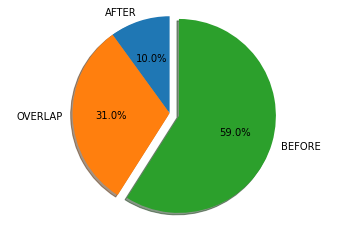

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = list(TLINK_map.keys())
sizes = dist
explode = (0, 0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

## Token Distance

The text is tokenized and the distances between tokens are calculated.

In [ ]:
# Import tokenizer 
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Add special tokens
extra_tokens = ['[L]', '[R]']
tokenizer.add_tokens(extra_tokens, special_tokens=True)

left_token = tokenizer.convert_tokens_to_ids('[L]')
right_token = tokenizer.convert_tokens_to_ids('[R]')
print(left_token, right_token)


28996 28997


In [ ]:
# Calculate distance between entity pairs
def get_distances(results):
    results['Token'] = results['Text'].apply(lambda x: tokenizer.encode(x, return_tensors='np'))
    results['left_0'] = results['Token'].apply(lambda x: np.where(x[0] == left_token)[0][0])
    results['left_1'] = results['Token'].apply(lambda x: np.where(x[0] == left_token)[0][1])
    results['right_0'] = results['Token'].apply(lambda x: np.where(x[0] == right_token)[0][0])
    results['right_1'] = results['Token'].apply(lambda x: np.where(x[0] == right_token)[0][1])

    results = results.drop('Token', axis=1)
#     results = results.drop('Unnamed: 0', axis=1)

    # Since the order b/w [L] and [R] maybe flipped, use shortest distance
    results['left_right'] = abs(results['left_1'] - results['right_0']) 
    results['right_left'] = abs(results['right_1'] - results['left_0']) 

    results['distance'] = results[['left_right', 'right_left']].min(axis=1)
    
    return results

train_df = get_distances(train_df)
test_df = get_distances(test_df)

In [ ]:
# Buckets for distance
buckets = ['<256', '<512', '<768', '<1024', '>0']
bucket_dist = [
np.sum((train_df['dist'] < 256))/train_df.shape[0],
np.sum((train_df['dist'] < 512))/train_df.shape[0],
np.sum((train_df['dist'] < 768))/train_df.shape[0],
np.sum((train_df['dist'] < 1024))/train_df.shape[0],
np.sum((train_df['dist'] > 0))/train_df.shape[0]]

Text(0, 0.5, 'Fraction of Total Entity Pairs')

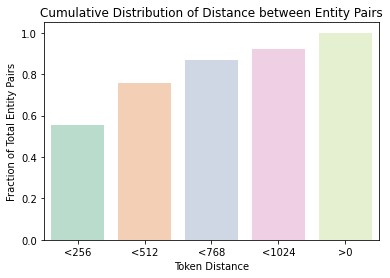

In [ ]:
# Graph
ax = sns.barplot(x=buckets, y=bucket_dist, palette='Pastel2')
plt.title('Cumulative Distribution of Distance between Entity Pairs')
plt.xlabel('Token Distance')
plt.ylabel('Fraction of Total Entity Pairs')

## Entities from the start

Find the fraction of tokens excluded when truncating at 512

In [ ]:
# Buckets
buckets = ['<256', '<512', '<768', '<1024', '>0']

entities_pairs_from_start = [
np.sum((train_df['left_1'] < 256) & (train_df['right_1'] < 256))/train_df.shape[0],
np.sum((train_df['left_1'] < 512) & (train_df['right_1'] < 512))/train_df.shape[0],
np.sum((train_df['left_1'] < 768) & (train_df['right_1'] < 768))/train_df.shape[0],
np.sum((train_df['left_1'] < 1024) & (train_df['right_1'] < 1024))/train_df.shape[0],
np.sum((train_df['left_1'] > 0) & (train_df['right_1'] > 0))/train_df.shape[0]]

entities_pairs_from_start

[0.32354105281674655,
 0.6314701613967193,
 0.7993755222305291,
 0.8779629711069088,
 1.0]

Text(0, 0.5, 'Fraction of Total Entity Pairs')

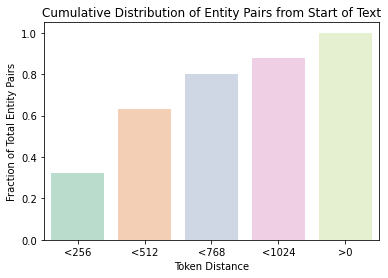

In [ ]:
# Graph
sns.barplot(x=buckets, y=entities_pairs_from_start, palette='Pastel2')
plt.title('Cumulative Distribution of Entity Pairs from Start of Text')
plt.xlabel('Token Distance')
plt.ylabel('Fraction of Total Entity Pairs')

# Prepare Subset of Data

In [ ]:
# Get data that has both left and right embeddings shorter than 500, to give room for tokenizer incase 512
short_train_df = train_df[(train_df['left_1'] < 500) & (train_df['right_1'] < 500)]
short_test_df = test_df[(test_df['left_1'] < 500) & (test_df['right_1'] < 500)]

print(short_train_df.shape)
print(short_test_df.shape)

In [ ]:
# Create a mini dataset to randomize
mini_df = short_train_df.sample(short_train_df.shape[0]).reset_index().drop('index', axis=1)
mini_test_df = short_test_df.sample(short_test_df.shape[0]).reset_index().drop('index', axis=1)

mini_df.head()

In [ ]:
# Map labels to numbers
TLINK_map = {'AFTER':0,
             'OVERLAP': 1,
             'BEFORE': 2}

y_mini = np.asarray(mini_df['TLINK'].apply(lambda x: TLINK_map[x])).reshape(-1,1)
y_mini_test = np.asarray(mini_test_df['TLINK'].apply(lambda x: TLINK_map[x])).reshape(-1,1)

# Distribution
print('train')
dist = np.unique(y_mini, return_counts=True)[1]/sum(np.unique(y_mini return_counts=True)[1])
print(dist)

print()
print('test')
dist = np.unique(y_mini_test, return_counts=True)[1]/sum(np.unique(y_mini_test, return_counts=True)[1])
print(dist)

In [ ]:
# Resample to balance class
def create_resample(tlink_map = TLINK_map, sample_size=25, labels=None, features=None):
    resample_df = pd.DataFrame(columns = features.columns)
    for i in list(TLINK_map.values()):
        all_idx = np.where(labels == i)[0]
        rand_idx = np.random.choice(all_idx, sample_size)
        sample_df = features.iloc[rand_idx, :]
        resample_df = pd.concat([resample_df, sample_df], axis=0)
        resample_df = resample_df.sample(frac=1)
        resample_labels = np.asarray(resample_df ['TLINK'].apply(lambda x: TLINK_map[x])).reshape(-1,1)

    counts = np.unique(resample_labels, return_counts=True)[1]
    print(counts/np.sum(counts))

    return resample_df.reset_index().drop('index', axis=1), resample_labels

In [ ]:
resample_df, y_resample = create_resample(tlink_map=TLINK_map, 
                                        sample_size=3000, 
                                        labels=y_mini, 
                                        features=mini_df)
print(resample_df.shape)
resample_class_weights = {0:1, 1:1, 2:1}

In [ ]:
# Train data distribution
import seaborn as sns
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i in range(0, 3):
    temp = resample_df[y_resample==i]['distance']
    title = ['AFTER', 'OVERLAP', 'BEFORE']

    buckets = ['<16', '16-32', '32-64', '64-128', '128-256', '256-512']
    bucket_dist = [
    np.sum(temp < 16)/len(temp) ,              
    np.sum((temp >= 16) & (temp < 32))/len(temp),
    np.sum((temp >= 32) & (temp < 64))/len(temp),
    np.sum((temp >= 64) & (temp < 128))/len(temp),
    np.sum((temp >= 128) & (temp < 256))/len(temp),
    np.sum((temp >= 256) & (temp < 512))/len(temp)]

    sns.barplot(ax=ax[i], x=buckets, y=bucket_dist, palette='Pastel2')
    ax[i].set_title(title[i])
    ax[i].set_xlabel('Token Distance b/w Entities')
    ax[i].set_ylabel('Fraction of Total Samples in Train (Resampled)')
    ax[i].set_ylim(0, 0.6)

In [ ]:
# Save datasets
mini_df.to_csv('mini_df.csv')
mini_test_df.to_csv('mini_test_df.csv')
resample_df.to_csv('resample_df.csv')